In [2]:
from json_file_func import *
from TPF import *
import pandas as pd
import numpy as np
from df_functions import *

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [42]:
X_file_path = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\labels_count_table-H7-60-30.csv"
y_file_path = r"C:\final_project\H1H7 test Yonatan imputated.csv"
output_folder = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count"
train_or_test = 'H7_6030'
hs_md_hsmd = ''
label = 'HDRS21_Change_CenteredByStite'

In [43]:
merge_x_and_y(X_file_path, y_file_path, output_folder, train_or_test, hs_md_hsmd,label)

In [44]:
df=pd.read_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\X_H7_6030__on_HDRS21_Change_CenteredByStite.csv")

In [45]:
len(df)

534

In [46]:
df['subject'] = df["Id"].str[0:5]
df['HDRS21_improvement_CenteredByStite'] = df['HDRS21_Change_CenteredByStite']*(-1)
median_value = df['HDRS21_improvement_CenteredByStite'].median()


# Step 2: Create a new label column
df['above_median_HDRS21_improvement_CenteredByStite'] =  df['HDRS21_improvement_CenteredByStite'].apply(lambda x: 1.0 if x > median_value else 0.0)

<Axes: >

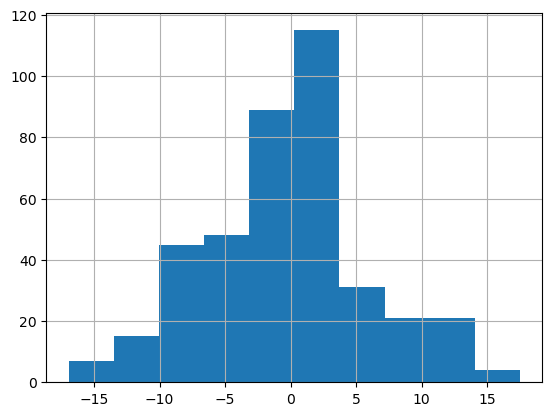

In [26]:
df['HDRS21_improvement_CenteredByStite'].hist()

In [27]:
median_value

0.239130435

In [47]:
subject = 'subject'
label = 'above_median_HDRS21_improvement_CenteredByStite'

best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=72)

In [48]:
original_df_label_ratio

0.0    0.524345
1.0    0.475655
Name: above_median_HDRS21_improvement_CenteredByStite, dtype: float64

In [49]:
best_split_label_ratio

0.0    0.518519
1.0    0.481481
Name: above_median_HDRS21_improvement_CenteredByStite, dtype: float64

In [53]:
def filter_by_percentile(df, column):
    column_data = df[column]
    threshold_high = column_data.quantile(0.60)
    threshold_low = column_data.quantile(0.40)
    filtered_df = df[(column_data > threshold_high) | (column_data < threshold_low)]
    return filtered_df

In [32]:
from sklearn.model_selection import GroupKFold

In [54]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import GroupKFold

models = ['XGBoost', 'RandomForest', 'Catboost', 'TPF', 'TPF_top3', 'TPF_top5', 'TPF_top7', 'TPF_top9', 'TPF_top11', 'TPF_top13', 'TPF_top15']
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
predictions = {}

# Create a GroupKFold object based on the 'subject' column
group_kfold = GroupKFold(n_splits=len(df['subject'].unique()))

for model_name in models:
    predictions[model_name] = {}
    y_pred = np.zeros(len(df))  # Initialize y_pred with zeros for the current model


    for train_index, test_index in group_kfold.split(df, groups=df['subject']):
        train_df = df.iloc[train_index]  # Training data for the current subject group
        test_df = df.iloc[test_index]  # Test data for the current subject group
        train_df = filter_by_percentile(train_df, 'HDRS21_improvement_CenteredByStite')
        X_train = train_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
        X_test = test_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
        y_train = train_df["above_median_HDRS21_improvement_CenteredByStite"]
        y_test = test_df["above_median_HDRS21_improvement_CenteredByStite"]

        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        if model_name == 'XGBoost':
            model = XGBClassifier(n_estimators = 100, max_depth = 6, learning_rate =0.1)
            model.fit(scaled_X_train, y_train)
            y_pred[test_index] = model.predict(scaled_X_test)
        elif model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators = 100, max_depth =5, max_features ='sqrt')
            model.fit(scaled_X_train, y_train)
            y_pred[test_index] = model.predict(scaled_X_test)
        elif model_name == 'Catboost':
            model = CatBoostClassifier(
                iterations=100,
                learning_rate=0.1,
                depth=6,
                l2_leaf_reg=1,
                random_strength=0.5,
                border_count=32,
                random_state=42
            )
            model.fit(scaled_X_train, y_train)
            y_pred[test_index] = model.predict(scaled_X_test)
        elif model_name == 'TPF':
            y_pred[test_index] = TPF_classifier(pd.DataFrame(scaled_X_train),y_train,pd.DataFrame(scaled_X_test),y_test)
        elif model_name == 'TPF_top3':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=3)
        elif model_name == 'TPF_top5':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=5)
        elif model_name == 'TPF_top7':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=7)
        elif model_name == 'TPF_top9':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=9)
        elif model_name == 'TPF_top11':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=11)
        elif model_name == 'TPF_top13':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=13)
        elif model_name == 'TPF_top15':
            y_pred[test_index] = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=15)
            
        for row_index in df.index:
            predictions[model_name][row_index] = y_pred[row_index]

# Calculate metrics for each model based on all predictions
results = {}
for model_name in models:
    model_predictions = predictions[model_name]
    all_y_true = df['above_median_HDRS21_improvement_CenteredByStite'].values  # Convert to array
    all_y_pred = [model_predictions.get(row_index) for row_index in df.index]
    
    accuracy = accuracy_score(all_y_true, all_y_pred)
    sensitivity = recall_score(all_y_true, all_y_pred)
    specificity = recall_score(all_y_true, all_y_pred, pos_label=0)

    results[model_name] = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

# Create a DataFrame to display the results
combined_results = pd.DataFrame.from_dict(results, orient='index')


0:	learn: 0.5889573	total: 15.5ms	remaining: 1.54s
1:	learn: 0.5236216	total: 27.7ms	remaining: 1.35s
2:	learn: 0.4335173	total: 40.5ms	remaining: 1.31s
3:	learn: 0.4003260	total: 51.2ms	remaining: 1.23s
4:	learn: 0.3517226	total: 61.4ms	remaining: 1.17s
5:	learn: 0.3068291	total: 80.1ms	remaining: 1.25s
6:	learn: 0.2692533	total: 90.1ms	remaining: 1.2s
7:	learn: 0.2202614	total: 100ms	remaining: 1.16s
8:	learn: 0.1933728	total: 111ms	remaining: 1.12s
9:	learn: 0.1755357	total: 122ms	remaining: 1.1s
10:	learn: 0.1548974	total: 133ms	remaining: 1.08s
11:	learn: 0.1333755	total: 144ms	remaining: 1.06s
12:	learn: 0.1223253	total: 155ms	remaining: 1.04s
13:	learn: 0.1114330	total: 167ms	remaining: 1.02s
14:	learn: 0.1031035	total: 184ms	remaining: 1.04s
15:	learn: 0.0896861	total: 196ms	remaining: 1.03s
16:	learn: 0.0846014	total: 208ms	remaining: 1.01s
17:	learn: 0.0754824	total: 220ms	remaining: 1s
18:	learn: 0.0708364	total: 233ms	remaining: 991ms
19:	learn: 0.0643476	total: 248ms	remai

69:	learn: 0.0051727	total: 793ms	remaining: 340ms
70:	learn: 0.0050426	total: 806ms	remaining: 329ms
71:	learn: 0.0049052	total: 822ms	remaining: 320ms
72:	learn: 0.0047419	total: 835ms	remaining: 309ms
73:	learn: 0.0046124	total: 852ms	remaining: 299ms
74:	learn: 0.0044711	total: 864ms	remaining: 288ms
75:	learn: 0.0043377	total: 877ms	remaining: 277ms
76:	learn: 0.0041852	total: 890ms	remaining: 266ms
77:	learn: 0.0040471	total: 902ms	remaining: 254ms
78:	learn: 0.0039501	total: 913ms	remaining: 243ms
79:	learn: 0.0038110	total: 924ms	remaining: 231ms
80:	learn: 0.0037071	total: 935ms	remaining: 219ms
81:	learn: 0.0036271	total: 946ms	remaining: 208ms
82:	learn: 0.0035293	total: 957ms	remaining: 196ms
83:	learn: 0.0034720	total: 969ms	remaining: 184ms
84:	learn: 0.0033732	total: 979ms	remaining: 173ms
85:	learn: 0.0032972	total: 991ms	remaining: 161ms
86:	learn: 0.0032252	total: 1s	remaining: 150ms
87:	learn: 0.0031422	total: 1.02s	remaining: 140ms
88:	learn: 0.0030514	total: 1.03s	

32:	learn: 0.0273354	total: 361ms	remaining: 732ms
33:	learn: 0.0255791	total: 376ms	remaining: 730ms
34:	learn: 0.0242351	total: 388ms	remaining: 721ms
35:	learn: 0.0222746	total: 399ms	remaining: 709ms
36:	learn: 0.0213503	total: 410ms	remaining: 698ms
37:	learn: 0.0201559	total: 420ms	remaining: 686ms
38:	learn: 0.0190529	total: 431ms	remaining: 674ms
39:	learn: 0.0183553	total: 441ms	remaining: 662ms
40:	learn: 0.0173507	total: 452ms	remaining: 650ms
41:	learn: 0.0167644	total: 462ms	remaining: 638ms
42:	learn: 0.0162808	total: 473ms	remaining: 626ms
43:	learn: 0.0151220	total: 483ms	remaining: 615ms
44:	learn: 0.0144749	total: 500ms	remaining: 611ms
45:	learn: 0.0138125	total: 510ms	remaining: 599ms
46:	learn: 0.0128675	total: 520ms	remaining: 586ms
47:	learn: 0.0122322	total: 530ms	remaining: 575ms
48:	learn: 0.0116347	total: 541ms	remaining: 564ms
49:	learn: 0.0112629	total: 552ms	remaining: 552ms
50:	learn: 0.0106313	total: 563ms	remaining: 541ms
51:	learn: 0.0102082	total: 576

4:	learn: 0.3762777	total: 68.2ms	remaining: 1.3s
5:	learn: 0.3117448	total: 81.8ms	remaining: 1.28s
6:	learn: 0.2814008	total: 97.2ms	remaining: 1.29s
7:	learn: 0.2402291	total: 109ms	remaining: 1.25s
8:	learn: 0.2183505	total: 121ms	remaining: 1.22s
9:	learn: 0.1951169	total: 133ms	remaining: 1.2s
10:	learn: 0.1745236	total: 145ms	remaining: 1.17s
11:	learn: 0.1566287	total: 157ms	remaining: 1.15s
12:	learn: 0.1423556	total: 168ms	remaining: 1.13s
13:	learn: 0.1302990	total: 181ms	remaining: 1.11s
14:	learn: 0.1197308	total: 193ms	remaining: 1.09s
15:	learn: 0.1030257	total: 205ms	remaining: 1.08s
16:	learn: 0.0960529	total: 217ms	remaining: 1.06s
17:	learn: 0.0888563	total: 229ms	remaining: 1.04s
18:	learn: 0.0791417	total: 242ms	remaining: 1.03s
19:	learn: 0.0697907	total: 256ms	remaining: 1.02s
20:	learn: 0.0633061	total: 268ms	remaining: 1.01s
21:	learn: 0.0589143	total: 279ms	remaining: 990ms
22:	learn: 0.0541014	total: 300ms	remaining: 1s
23:	learn: 0.0494155	total: 312ms	remai

83:	learn: 0.0034682	total: 856ms	remaining: 163ms
84:	learn: 0.0033872	total: 877ms	remaining: 155ms
85:	learn: 0.0033210	total: 890ms	remaining: 145ms
86:	learn: 0.0032104	total: 900ms	remaining: 134ms
87:	learn: 0.0031400	total: 909ms	remaining: 124ms
88:	learn: 0.0030796	total: 919ms	remaining: 114ms
89:	learn: 0.0030244	total: 928ms	remaining: 103ms
90:	learn: 0.0029549	total: 939ms	remaining: 92.9ms
91:	learn: 0.0028968	total: 948ms	remaining: 82.5ms
92:	learn: 0.0028538	total: 957ms	remaining: 72.1ms
93:	learn: 0.0028044	total: 967ms	remaining: 61.7ms
94:	learn: 0.0027276	total: 976ms	remaining: 51.4ms
95:	learn: 0.0026803	total: 985ms	remaining: 41.1ms
96:	learn: 0.0026063	total: 996ms	remaining: 30.8ms
97:	learn: 0.0025406	total: 1s	remaining: 20.5ms
98:	learn: 0.0024760	total: 1.01s	remaining: 10.3ms
99:	learn: 0.0024360	total: 1.02s	remaining: 0us
0:	learn: 0.6038605	total: 11.5ms	remaining: 1.14s
1:	learn: 0.5091839	total: 21.1ms	remaining: 1.03s
2:	learn: 0.4210526	total: 

47:	learn: 0.0126915	total: 466ms	remaining: 505ms
48:	learn: 0.0122130	total: 476ms	remaining: 496ms
49:	learn: 0.0117700	total: 488ms	remaining: 488ms
50:	learn: 0.0111792	total: 497ms	remaining: 477ms
51:	learn: 0.0107644	total: 506ms	remaining: 467ms
52:	learn: 0.0102710	total: 515ms	remaining: 456ms
53:	learn: 0.0098052	total: 523ms	remaining: 446ms
54:	learn: 0.0094372	total: 532ms	remaining: 435ms
55:	learn: 0.0090328	total: 542ms	remaining: 426ms
56:	learn: 0.0087194	total: 551ms	remaining: 415ms
57:	learn: 0.0083241	total: 559ms	remaining: 405ms
58:	learn: 0.0079665	total: 568ms	remaining: 395ms
59:	learn: 0.0075751	total: 577ms	remaining: 385ms
60:	learn: 0.0071987	total: 586ms	remaining: 375ms
61:	learn: 0.0068799	total: 595ms	remaining: 365ms
62:	learn: 0.0065591	total: 604ms	remaining: 355ms
63:	learn: 0.0062171	total: 613ms	remaining: 345ms
64:	learn: 0.0060350	total: 622ms	remaining: 335ms
65:	learn: 0.0057671	total: 631ms	remaining: 325ms
66:	learn: 0.0055697	total: 640

10:	learn: 0.1766437	total: 112ms	remaining: 906ms
11:	learn: 0.1616737	total: 125ms	remaining: 913ms
12:	learn: 0.1406230	total: 134ms	remaining: 896ms
13:	learn: 0.1299400	total: 143ms	remaining: 879ms
14:	learn: 0.1212842	total: 152ms	remaining: 863ms
15:	learn: 0.1106922	total: 161ms	remaining: 847ms
16:	learn: 0.1027893	total: 170ms	remaining: 831ms
17:	learn: 0.0890437	total: 180ms	remaining: 818ms
18:	learn: 0.0810183	total: 188ms	remaining: 804ms
19:	learn: 0.0777846	total: 198ms	remaining: 793ms
20:	learn: 0.0710095	total: 207ms	remaining: 781ms
21:	learn: 0.0649040	total: 217ms	remaining: 768ms
22:	learn: 0.0601808	total: 226ms	remaining: 757ms
23:	learn: 0.0557158	total: 235ms	remaining: 744ms
24:	learn: 0.0497851	total: 244ms	remaining: 732ms
25:	learn: 0.0460999	total: 253ms	remaining: 720ms
26:	learn: 0.0434725	total: 263ms	remaining: 710ms
27:	learn: 0.0406700	total: 272ms	remaining: 699ms
28:	learn: 0.0383565	total: 281ms	remaining: 688ms
29:	learn: 0.0357134	total: 290

77:	learn: 0.0038901	total: 765ms	remaining: 216ms
78:	learn: 0.0037567	total: 777ms	remaining: 207ms
79:	learn: 0.0036507	total: 789ms	remaining: 197ms
80:	learn: 0.0035042	total: 799ms	remaining: 187ms
81:	learn: 0.0034135	total: 808ms	remaining: 177ms
82:	learn: 0.0033469	total: 817ms	remaining: 167ms
83:	learn: 0.0032518	total: 827ms	remaining: 157ms
84:	learn: 0.0031875	total: 836ms	remaining: 148ms
85:	learn: 0.0031289	total: 846ms	remaining: 138ms
86:	learn: 0.0030427	total: 855ms	remaining: 128ms
87:	learn: 0.0029742	total: 864ms	remaining: 118ms
88:	learn: 0.0028941	total: 879ms	remaining: 109ms
89:	learn: 0.0028467	total: 889ms	remaining: 98.8ms
90:	learn: 0.0027925	total: 902ms	remaining: 89.3ms
91:	learn: 0.0027363	total: 914ms	remaining: 79.5ms
92:	learn: 0.0026710	total: 925ms	remaining: 69.7ms
93:	learn: 0.0026252	total: 936ms	remaining: 59.7ms
94:	learn: 0.0025745	total: 945ms	remaining: 49.7ms
95:	learn: 0.0025157	total: 954ms	remaining: 39.8ms
96:	learn: 0.0024533	tot

45:	learn: 0.0132300	total: 436ms	remaining: 512ms
46:	learn: 0.0127041	total: 447ms	remaining: 505ms
47:	learn: 0.0121000	total: 459ms	remaining: 497ms
48:	learn: 0.0117292	total: 468ms	remaining: 487ms
49:	learn: 0.0112448	total: 477ms	remaining: 477ms
50:	learn: 0.0108035	total: 486ms	remaining: 467ms
51:	learn: 0.0102679	total: 496ms	remaining: 458ms
52:	learn: 0.0098417	total: 505ms	remaining: 448ms
53:	learn: 0.0094008	total: 516ms	remaining: 440ms
54:	learn: 0.0090955	total: 525ms	remaining: 430ms
55:	learn: 0.0086428	total: 535ms	remaining: 420ms
56:	learn: 0.0083669	total: 544ms	remaining: 411ms
57:	learn: 0.0080681	total: 554ms	remaining: 401ms
58:	learn: 0.0077979	total: 563ms	remaining: 392ms
59:	learn: 0.0075583	total: 573ms	remaining: 382ms
60:	learn: 0.0072462	total: 583ms	remaining: 373ms
61:	learn: 0.0069846	total: 592ms	remaining: 363ms
62:	learn: 0.0067450	total: 601ms	remaining: 353ms
63:	learn: 0.0064970	total: 610ms	remaining: 343ms
64:	learn: 0.0061813	total: 624

22:	learn: 0.0544488	total: 217ms	remaining: 728ms
23:	learn: 0.0507991	total: 230ms	remaining: 730ms
24:	learn: 0.0469872	total: 246ms	remaining: 738ms
25:	learn: 0.0441210	total: 258ms	remaining: 735ms
26:	learn: 0.0418410	total: 270ms	remaining: 731ms
27:	learn: 0.0389610	total: 282ms	remaining: 726ms
28:	learn: 0.0369141	total: 294ms	remaining: 719ms
29:	learn: 0.0350550	total: 306ms	remaining: 714ms
30:	learn: 0.0330099	total: 317ms	remaining: 707ms
31:	learn: 0.0313407	total: 327ms	remaining: 695ms
32:	learn: 0.0292728	total: 336ms	remaining: 683ms
33:	learn: 0.0282668	total: 346ms	remaining: 672ms
34:	learn: 0.0266003	total: 356ms	remaining: 660ms
35:	learn: 0.0255239	total: 365ms	remaining: 649ms
36:	learn: 0.0235552	total: 374ms	remaining: 637ms
37:	learn: 0.0225759	total: 383ms	remaining: 625ms
38:	learn: 0.0206413	total: 393ms	remaining: 614ms
39:	learn: 0.0195350	total: 402ms	remaining: 603ms
40:	learn: 0.0186010	total: 412ms	remaining: 593ms
41:	learn: 0.0178191	total: 422

98:	learn: 0.0020940	total: 1.1s	remaining: 11.1ms
99:	learn: 0.0020636	total: 1.11s	remaining: 0us
0:	learn: 0.6054887	total: 10.6ms	remaining: 1.04s
1:	learn: 0.5123453	total: 19.9ms	remaining: 975ms
2:	learn: 0.4609905	total: 28.6ms	remaining: 925ms
3:	learn: 0.4146275	total: 38.5ms	remaining: 924ms
4:	learn: 0.3701172	total: 47.3ms	remaining: 899ms
5:	learn: 0.3330334	total: 56.2ms	remaining: 880ms
6:	learn: 0.2945635	total: 65ms	remaining: 863ms
7:	learn: 0.2598455	total: 73.6ms	remaining: 847ms
8:	learn: 0.2419437	total: 82.4ms	remaining: 833ms
9:	learn: 0.2116070	total: 91.3ms	remaining: 821ms
10:	learn: 0.1929237	total: 100ms	remaining: 812ms
11:	learn: 0.1667811	total: 110ms	remaining: 804ms
12:	learn: 0.1445956	total: 118ms	remaining: 793ms
13:	learn: 0.1348541	total: 127ms	remaining: 783ms
14:	learn: 0.1238862	total: 136ms	remaining: 772ms
15:	learn: 0.1117239	total: 147ms	remaining: 771ms
16:	learn: 0.0990720	total: 159ms	remaining: 775ms
17:	learn: 0.0904357	total: 169ms	r

65:	learn: 0.0051426	total: 732ms	remaining: 377ms
66:	learn: 0.0049585	total: 745ms	remaining: 367ms
67:	learn: 0.0048140	total: 754ms	remaining: 355ms
68:	learn: 0.0046384	total: 764ms	remaining: 343ms
69:	learn: 0.0044406	total: 773ms	remaining: 331ms
70:	learn: 0.0043300	total: 782ms	remaining: 320ms
71:	learn: 0.0042096	total: 792ms	remaining: 308ms
72:	learn: 0.0041087	total: 801ms	remaining: 296ms
73:	learn: 0.0039649	total: 810ms	remaining: 285ms
74:	learn: 0.0038657	total: 820ms	remaining: 273ms
75:	learn: 0.0037309	total: 829ms	remaining: 262ms
76:	learn: 0.0036115	total: 838ms	remaining: 250ms
77:	learn: 0.0034829	total: 848ms	remaining: 239ms
78:	learn: 0.0033870	total: 857ms	remaining: 228ms
79:	learn: 0.0033054	total: 868ms	remaining: 217ms
80:	learn: 0.0032255	total: 878ms	remaining: 206ms
81:	learn: 0.0031791	total: 888ms	remaining: 195ms
82:	learn: 0.0031110	total: 898ms	remaining: 184ms
83:	learn: 0.0030433	total: 907ms	remaining: 173ms
84:	learn: 0.0029757	total: 917

38:	learn: 0.0199992	total: 487ms	remaining: 762ms
39:	learn: 0.0188019	total: 501ms	remaining: 752ms
40:	learn: 0.0175121	total: 517ms	remaining: 744ms
41:	learn: 0.0164896	total: 529ms	remaining: 730ms
42:	learn: 0.0154523	total: 540ms	remaining: 715ms
43:	learn: 0.0146441	total: 550ms	remaining: 700ms
44:	learn: 0.0138627	total: 561ms	remaining: 685ms
45:	learn: 0.0129078	total: 572ms	remaining: 671ms
46:	learn: 0.0123984	total: 582ms	remaining: 657ms
47:	learn: 0.0119868	total: 593ms	remaining: 642ms
48:	learn: 0.0113763	total: 604ms	remaining: 628ms
49:	learn: 0.0106320	total: 614ms	remaining: 614ms
50:	learn: 0.0101441	total: 625ms	remaining: 600ms
51:	learn: 0.0096873	total: 635ms	remaining: 586ms
52:	learn: 0.0091225	total: 646ms	remaining: 573ms
53:	learn: 0.0087145	total: 656ms	remaining: 559ms
54:	learn: 0.0084397	total: 666ms	remaining: 545ms
55:	learn: 0.0080740	total: 677ms	remaining: 532ms
56:	learn: 0.0076617	total: 688ms	remaining: 519ms
57:	learn: 0.0074694	total: 700

8:	learn: 0.1964843	total: 95.9ms	remaining: 969ms
9:	learn: 0.1762234	total: 108ms	remaining: 975ms
10:	learn: 0.1557502	total: 121ms	remaining: 979ms
11:	learn: 0.1417709	total: 132ms	remaining: 969ms
12:	learn: 0.1252117	total: 142ms	remaining: 952ms
13:	learn: 0.1144223	total: 153ms	remaining: 938ms
14:	learn: 0.1066599	total: 164ms	remaining: 928ms
15:	learn: 0.0948477	total: 176ms	remaining: 925ms
16:	learn: 0.0863533	total: 189ms	remaining: 920ms
17:	learn: 0.0775010	total: 200ms	remaining: 912ms
18:	learn: 0.0691316	total: 213ms	remaining: 906ms
19:	learn: 0.0623975	total: 224ms	remaining: 897ms
20:	learn: 0.0587409	total: 238ms	remaining: 897ms
21:	learn: 0.0537359	total: 254ms	remaining: 899ms
22:	learn: 0.0499030	total: 266ms	remaining: 892ms
23:	learn: 0.0466050	total: 277ms	remaining: 878ms
24:	learn: 0.0431314	total: 288ms	remaining: 865ms
25:	learn: 0.0381301	total: 299ms	remaining: 851ms
26:	learn: 0.0355771	total: 311ms	remaining: 841ms
27:	learn: 0.0326404	total: 325m

83:	learn: 0.0031671	total: 868ms	remaining: 165ms
84:	learn: 0.0030600	total: 881ms	remaining: 155ms
85:	learn: 0.0029925	total: 893ms	remaining: 145ms
86:	learn: 0.0029066	total: 903ms	remaining: 135ms
87:	learn: 0.0028394	total: 913ms	remaining: 124ms
88:	learn: 0.0027725	total: 923ms	remaining: 114ms
89:	learn: 0.0027247	total: 932ms	remaining: 104ms
90:	learn: 0.0026657	total: 942ms	remaining: 93.2ms
91:	learn: 0.0026044	total: 951ms	remaining: 82.7ms
92:	learn: 0.0025389	total: 960ms	remaining: 72.3ms
93:	learn: 0.0024902	total: 970ms	remaining: 61.9ms
94:	learn: 0.0024493	total: 979ms	remaining: 51.5ms
95:	learn: 0.0024131	total: 989ms	remaining: 41.2ms
96:	learn: 0.0023681	total: 998ms	remaining: 30.9ms
97:	learn: 0.0023265	total: 1.01s	remaining: 20.6ms
98:	learn: 0.0022692	total: 1.02s	remaining: 10.3ms
99:	learn: 0.0022361	total: 1.03s	remaining: 0us
0:	learn: 0.5945528	total: 16.7ms	remaining: 1.66s
1:	learn: 0.5118830	total: 28.1ms	remaining: 1.38s
2:	learn: 0.4298249	tota

50:	learn: 0.0097375	total: 560ms	remaining: 538ms
51:	learn: 0.0093781	total: 572ms	remaining: 528ms
52:	learn: 0.0090910	total: 583ms	remaining: 517ms
53:	learn: 0.0087693	total: 594ms	remaining: 506ms
54:	learn: 0.0083444	total: 607ms	remaining: 497ms
55:	learn: 0.0080615	total: 619ms	remaining: 486ms
56:	learn: 0.0076616	total: 630ms	remaining: 475ms
57:	learn: 0.0071441	total: 641ms	remaining: 464ms
58:	learn: 0.0069473	total: 651ms	remaining: 453ms
59:	learn: 0.0067766	total: 661ms	remaining: 441ms
60:	learn: 0.0065443	total: 672ms	remaining: 429ms
61:	learn: 0.0062662	total: 682ms	remaining: 418ms
62:	learn: 0.0058977	total: 692ms	remaining: 406ms
63:	learn: 0.0056834	total: 702ms	remaining: 395ms
64:	learn: 0.0055340	total: 712ms	remaining: 383ms
65:	learn: 0.0053525	total: 722ms	remaining: 372ms
66:	learn: 0.0052262	total: 732ms	remaining: 361ms
67:	learn: 0.0049910	total: 742ms	remaining: 349ms
68:	learn: 0.0048546	total: 752ms	remaining: 338ms
69:	learn: 0.0047088	total: 762

25:	learn: 0.0422483	total: 284ms	remaining: 809ms
26:	learn: 0.0399782	total: 297ms	remaining: 802ms
27:	learn: 0.0371839	total: 313ms	remaining: 804ms
28:	learn: 0.0354588	total: 329ms	remaining: 806ms
29:	learn: 0.0320858	total: 342ms	remaining: 798ms
30:	learn: 0.0300145	total: 355ms	remaining: 791ms
31:	learn: 0.0286064	total: 369ms	remaining: 784ms
32:	learn: 0.0267551	total: 382ms	remaining: 776ms
33:	learn: 0.0257435	total: 393ms	remaining: 763ms
34:	learn: 0.0244974	total: 403ms	remaining: 748ms
35:	learn: 0.0226518	total: 412ms	remaining: 733ms
36:	learn: 0.0214203	total: 422ms	remaining: 718ms
37:	learn: 0.0199329	total: 433ms	remaining: 706ms
38:	learn: 0.0189025	total: 442ms	remaining: 692ms
39:	learn: 0.0180220	total: 451ms	remaining: 677ms
40:	learn: 0.0173136	total: 461ms	remaining: 664ms
41:	learn: 0.0163345	total: 471ms	remaining: 651ms
42:	learn: 0.0152479	total: 481ms	remaining: 637ms
43:	learn: 0.0142574	total: 491ms	remaining: 625ms
44:	learn: 0.0136186	total: 503

93:	learn: 0.0026197	total: 1.08s	remaining: 69.1ms
94:	learn: 0.0025549	total: 1.09s	remaining: 57.7ms
95:	learn: 0.0025161	total: 1.11s	remaining: 46.2ms
96:	learn: 0.0024532	total: 1.12s	remaining: 34.7ms
97:	learn: 0.0024032	total: 1.14s	remaining: 23.2ms
98:	learn: 0.0023522	total: 1.15s	remaining: 11.6ms
99:	learn: 0.0022958	total: 1.16s	remaining: 0us
0:	learn: 0.6182455	total: 10.9ms	remaining: 1.08s
1:	learn: 0.5443781	total: 20.4ms	remaining: 1000ms
2:	learn: 0.4584702	total: 29.8ms	remaining: 963ms
3:	learn: 0.4173791	total: 39.1ms	remaining: 939ms
4:	learn: 0.3719187	total: 48.6ms	remaining: 923ms
5:	learn: 0.3305783	total: 57.6ms	remaining: 903ms
6:	learn: 0.3006043	total: 66.9ms	remaining: 888ms
7:	learn: 0.2735378	total: 76ms	remaining: 873ms
8:	learn: 0.2485718	total: 85.2ms	remaining: 861ms
9:	learn: 0.2177839	total: 94.5ms	remaining: 851ms
10:	learn: 0.1897745	total: 107ms	remaining: 868ms
11:	learn: 0.1663497	total: 120ms	remaining: 876ms
12:	learn: 0.1499372	total: 

69:	learn: 0.0043860	total: 701ms	remaining: 301ms
70:	learn: 0.0042045	total: 713ms	remaining: 291ms
71:	learn: 0.0040600	total: 724ms	remaining: 282ms
72:	learn: 0.0039621	total: 736ms	remaining: 272ms
73:	learn: 0.0038514	total: 746ms	remaining: 262ms
74:	learn: 0.0037454	total: 756ms	remaining: 252ms
75:	learn: 0.0036564	total: 765ms	remaining: 242ms
76:	learn: 0.0035728	total: 775ms	remaining: 231ms
77:	learn: 0.0034561	total: 784ms	remaining: 221ms
78:	learn: 0.0033457	total: 793ms	remaining: 211ms
79:	learn: 0.0032817	total: 803ms	remaining: 201ms
80:	learn: 0.0031870	total: 812ms	remaining: 190ms
81:	learn: 0.0031157	total: 821ms	remaining: 180ms
82:	learn: 0.0030286	total: 830ms	remaining: 170ms
83:	learn: 0.0029682	total: 840ms	remaining: 160ms
84:	learn: 0.0028849	total: 849ms	remaining: 150ms
85:	learn: 0.0028091	total: 859ms	remaining: 140ms
86:	learn: 0.0027249	total: 869ms	remaining: 130ms
87:	learn: 0.0026545	total: 878ms	remaining: 120ms
88:	learn: 0.0025804	total: 887

51:	learn: 0.0091631	total: 512ms	remaining: 473ms
52:	learn: 0.0088444	total: 523ms	remaining: 464ms
53:	learn: 0.0084447	total: 533ms	remaining: 454ms
54:	learn: 0.0081187	total: 542ms	remaining: 444ms
55:	learn: 0.0078592	total: 551ms	remaining: 433ms
56:	learn: 0.0074446	total: 561ms	remaining: 423ms
57:	learn: 0.0071636	total: 571ms	remaining: 414ms
58:	learn: 0.0068939	total: 581ms	remaining: 404ms
59:	learn: 0.0066797	total: 590ms	remaining: 393ms
60:	learn: 0.0064216	total: 599ms	remaining: 383ms
61:	learn: 0.0061413	total: 608ms	remaining: 373ms
62:	learn: 0.0059197	total: 617ms	remaining: 362ms
63:	learn: 0.0057099	total: 626ms	remaining: 352ms
64:	learn: 0.0055089	total: 635ms	remaining: 342ms
65:	learn: 0.0053259	total: 644ms	remaining: 332ms
66:	learn: 0.0051632	total: 652ms	remaining: 321ms
67:	learn: 0.0050369	total: 661ms	remaining: 311ms
68:	learn: 0.0048727	total: 670ms	remaining: 301ms
69:	learn: 0.0047201	total: 681ms	remaining: 292ms
70:	learn: 0.0046210	total: 693

18:	learn: 0.0787360	total: 252ms	remaining: 1.07s
19:	learn: 0.0693087	total: 264ms	remaining: 1.06s
20:	learn: 0.0621670	total: 276ms	remaining: 1.04s
21:	learn: 0.0583840	total: 287ms	remaining: 1.02s
22:	learn: 0.0544392	total: 297ms	remaining: 994ms
23:	learn: 0.0504617	total: 315ms	remaining: 996ms
24:	learn: 0.0458020	total: 326ms	remaining: 979ms
25:	learn: 0.0424844	total: 337ms	remaining: 960ms
26:	learn: 0.0400729	total: 348ms	remaining: 942ms
27:	learn: 0.0377322	total: 359ms	remaining: 924ms
28:	learn: 0.0358314	total: 370ms	remaining: 905ms
29:	learn: 0.0331787	total: 380ms	remaining: 887ms
30:	learn: 0.0306691	total: 391ms	remaining: 869ms
31:	learn: 0.0291013	total: 400ms	remaining: 850ms
32:	learn: 0.0278596	total: 410ms	remaining: 833ms
33:	learn: 0.0262125	total: 420ms	remaining: 815ms
34:	learn: 0.0246751	total: 430ms	remaining: 798ms
35:	learn: 0.0234394	total: 439ms	remaining: 781ms
36:	learn: 0.0221197	total: 450ms	remaining: 766ms
37:	learn: 0.0205193	total: 459

88:	learn: 0.0028941	total: 944ms	remaining: 117ms
89:	learn: 0.0028467	total: 957ms	remaining: 106ms
90:	learn: 0.0027925	total: 969ms	remaining: 95.9ms
91:	learn: 0.0027363	total: 980ms	remaining: 85.2ms
92:	learn: 0.0026710	total: 990ms	remaining: 74.5ms
93:	learn: 0.0026252	total: 1000ms	remaining: 63.8ms
94:	learn: 0.0025745	total: 1.01s	remaining: 53.1ms
95:	learn: 0.0025157	total: 1.02s	remaining: 42.5ms
96:	learn: 0.0024533	total: 1.03s	remaining: 31.9ms
97:	learn: 0.0024042	total: 1.04s	remaining: 21.2ms
98:	learn: 0.0023469	total: 1.05s	remaining: 10.6ms
99:	learn: 0.0023150	total: 1.06s	remaining: 0us
0:	learn: 0.5787704	total: 11.4ms	remaining: 1.13s
1:	learn: 0.4964115	total: 20.8ms	remaining: 1.02s
2:	learn: 0.4144271	total: 30.3ms	remaining: 979ms
3:	learn: 0.3757400	total: 39.6ms	remaining: 951ms
4:	learn: 0.3304749	total: 51.2ms	remaining: 973ms
5:	learn: 0.2894311	total: 61.6ms	remaining: 965ms
6:	learn: 0.2627072	total: 71.1ms	remaining: 945ms
7:	learn: 0.2395729	tot

67:	learn: 0.0048349	total: 673ms	remaining: 317ms
68:	learn: 0.0046369	total: 688ms	remaining: 309ms
69:	learn: 0.0045103	total: 700ms	remaining: 300ms
70:	learn: 0.0043969	total: 711ms	remaining: 291ms
71:	learn: 0.0042895	total: 722ms	remaining: 281ms
72:	learn: 0.0041664	total: 734ms	remaining: 271ms
73:	learn: 0.0040286	total: 744ms	remaining: 262ms
74:	learn: 0.0039020	total: 755ms	remaining: 252ms
75:	learn: 0.0038047	total: 766ms	remaining: 242ms
76:	learn: 0.0036749	total: 776ms	remaining: 232ms
77:	learn: 0.0035877	total: 785ms	remaining: 221ms
78:	learn: 0.0034846	total: 796ms	remaining: 211ms
79:	learn: 0.0034223	total: 806ms	remaining: 201ms
80:	learn: 0.0032957	total: 815ms	remaining: 191ms
81:	learn: 0.0032074	total: 825ms	remaining: 181ms
82:	learn: 0.0031009	total: 834ms	remaining: 171ms
83:	learn: 0.0030214	total: 843ms	remaining: 161ms
84:	learn: 0.0029458	total: 853ms	remaining: 151ms
85:	learn: 0.0028781	total: 862ms	remaining: 140ms
86:	learn: 0.0028262	total: 872

39:	learn: 0.0176225	total: 443ms	remaining: 664ms
40:	learn: 0.0167953	total: 464ms	remaining: 667ms
41:	learn: 0.0159591	total: 476ms	remaining: 657ms
42:	learn: 0.0151867	total: 488ms	remaining: 647ms
43:	learn: 0.0143593	total: 501ms	remaining: 638ms
44:	learn: 0.0135476	total: 513ms	remaining: 626ms
45:	learn: 0.0128148	total: 524ms	remaining: 615ms
46:	learn: 0.0121583	total: 536ms	remaining: 604ms
47:	learn: 0.0113926	total: 547ms	remaining: 593ms
48:	learn: 0.0107945	total: 559ms	remaining: 582ms
49:	learn: 0.0102803	total: 570ms	remaining: 570ms
50:	learn: 0.0095781	total: 580ms	remaining: 558ms
51:	learn: 0.0090936	total: 591ms	remaining: 545ms
52:	learn: 0.0086122	total: 601ms	remaining: 533ms
53:	learn: 0.0083089	total: 611ms	remaining: 521ms
54:	learn: 0.0080443	total: 622ms	remaining: 509ms
55:	learn: 0.0075420	total: 633ms	remaining: 497ms
56:	learn: 0.0072767	total: 644ms	remaining: 486ms
57:	learn: 0.0070205	total: 656ms	remaining: 475ms
58:	learn: 0.0067350	total: 674

0:	learn: 0.5618562	total: 13.3ms	remaining: 1.32s
1:	learn: 0.5100942	total: 22.8ms	remaining: 1.12s
2:	learn: 0.4146258	total: 32.1ms	remaining: 1.04s
3:	learn: 0.3678864	total: 41.1ms	remaining: 986ms
4:	learn: 0.3245175	total: 50.2ms	remaining: 953ms
5:	learn: 0.2998514	total: 59.1ms	remaining: 926ms
6:	learn: 0.2596944	total: 68.2ms	remaining: 906ms
7:	learn: 0.2377321	total: 77.3ms	remaining: 889ms
8:	learn: 0.2128212	total: 90.1ms	remaining: 911ms
9:	learn: 0.1871479	total: 99.8ms	remaining: 898ms
10:	learn: 0.1719125	total: 109ms	remaining: 879ms
11:	learn: 0.1519076	total: 118ms	remaining: 862ms
12:	learn: 0.1406079	total: 128ms	remaining: 854ms
13:	learn: 0.1291198	total: 138ms	remaining: 848ms
14:	learn: 0.1220919	total: 148ms	remaining: 841ms
15:	learn: 0.1103663	total: 158ms	remaining: 832ms
16:	learn: 0.0990847	total: 168ms	remaining: 823ms
17:	learn: 0.0915951	total: 179ms	remaining: 816ms
18:	learn: 0.0815896	total: 190ms	remaining: 809ms
19:	learn: 0.0740872	total: 200

74:	learn: 0.0039784	total: 825ms	remaining: 275ms
75:	learn: 0.0038633	total: 837ms	remaining: 264ms
76:	learn: 0.0037483	total: 850ms	remaining: 254ms
77:	learn: 0.0036599	total: 860ms	remaining: 243ms
78:	learn: 0.0035212	total: 871ms	remaining: 231ms
79:	learn: 0.0034103	total: 881ms	remaining: 220ms
80:	learn: 0.0033186	total: 891ms	remaining: 209ms
81:	learn: 0.0032434	total: 901ms	remaining: 198ms
82:	learn: 0.0031664	total: 911ms	remaining: 187ms
83:	learn: 0.0030940	total: 922ms	remaining: 176ms
84:	learn: 0.0030109	total: 933ms	remaining: 165ms
85:	learn: 0.0029155	total: 946ms	remaining: 154ms
86:	learn: 0.0028431	total: 958ms	remaining: 143ms
87:	learn: 0.0027728	total: 970ms	remaining: 132ms
88:	learn: 0.0026995	total: 982ms	remaining: 121ms
89:	learn: 0.0026213	total: 993ms	remaining: 110ms
90:	learn: 0.0025607	total: 1.01s	remaining: 99.5ms
91:	learn: 0.0025043	total: 1.03s	remaining: 89.2ms
92:	learn: 0.0024440	total: 1.04s	remaining: 78.1ms
93:	learn: 0.0024006	total: 

55:	learn: 0.0072939	total: 553ms	remaining: 435ms
56:	learn: 0.0069954	total: 564ms	remaining: 426ms
57:	learn: 0.0067124	total: 575ms	remaining: 416ms
58:	learn: 0.0064054	total: 585ms	remaining: 406ms
59:	learn: 0.0062166	total: 594ms	remaining: 396ms
60:	learn: 0.0060453	total: 604ms	remaining: 386ms
61:	learn: 0.0059091	total: 613ms	remaining: 376ms
62:	learn: 0.0056061	total: 627ms	remaining: 368ms
63:	learn: 0.0053364	total: 637ms	remaining: 358ms
64:	learn: 0.0051140	total: 647ms	remaining: 348ms
65:	learn: 0.0049342	total: 656ms	remaining: 338ms
66:	learn: 0.0047243	total: 665ms	remaining: 328ms
67:	learn: 0.0045787	total: 675ms	remaining: 318ms
68:	learn: 0.0044143	total: 684ms	remaining: 307ms
69:	learn: 0.0042886	total: 694ms	remaining: 297ms
70:	learn: 0.0041694	total: 703ms	remaining: 287ms
71:	learn: 0.0040644	total: 713ms	remaining: 277ms
72:	learn: 0.0039466	total: 723ms	remaining: 267ms
73:	learn: 0.0038192	total: 733ms	remaining: 258ms
74:	learn: 0.0036836	total: 742

33:	learn: 0.0268720	total: 329ms	remaining: 638ms
34:	learn: 0.0249894	total: 340ms	remaining: 631ms
35:	learn: 0.0234905	total: 351ms	remaining: 625ms
36:	learn: 0.0221442	total: 361ms	remaining: 614ms
37:	learn: 0.0211375	total: 370ms	remaining: 604ms
38:	learn: 0.0196269	total: 380ms	remaining: 594ms
39:	learn: 0.0182414	total: 389ms	remaining: 583ms
40:	learn: 0.0173367	total: 399ms	remaining: 574ms
41:	learn: 0.0164606	total: 408ms	remaining: 564ms
42:	learn: 0.0153458	total: 418ms	remaining: 554ms
43:	learn: 0.0145849	total: 427ms	remaining: 543ms
44:	learn: 0.0139290	total: 436ms	remaining: 533ms
45:	learn: 0.0132642	total: 446ms	remaining: 523ms
46:	learn: 0.0127687	total: 455ms	remaining: 513ms
47:	learn: 0.0121617	total: 464ms	remaining: 503ms
48:	learn: 0.0112702	total: 474ms	remaining: 493ms
49:	learn: 0.0108105	total: 483ms	remaining: 483ms
50:	learn: 0.0103463	total: 493ms	remaining: 474ms
51:	learn: 0.0098705	total: 507ms	remaining: 468ms
52:	learn: 0.0092009	total: 517

97:	learn: 0.0022594	total: 994ms	remaining: 20.3ms
98:	learn: 0.0022066	total: 1.01s	remaining: 10.2ms
99:	learn: 0.0021701	total: 1.02s	remaining: 0us
0:	learn: 0.5787704	total: 12.5ms	remaining: 1.24s
1:	learn: 0.4964115	total: 23.1ms	remaining: 1.13s
2:	learn: 0.4144271	total: 33.4ms	remaining: 1.08s
3:	learn: 0.3757400	total: 43ms	remaining: 1.03s
4:	learn: 0.3304749	total: 52.2ms	remaining: 991ms
5:	learn: 0.2894311	total: 61.5ms	remaining: 963ms
6:	learn: 0.2627072	total: 70.8ms	remaining: 941ms
7:	learn: 0.2395729	total: 80.1ms	remaining: 921ms
8:	learn: 0.2131498	total: 89.5ms	remaining: 905ms
9:	learn: 0.1922148	total: 100ms	remaining: 904ms
10:	learn: 0.1766437	total: 113ms	remaining: 913ms
11:	learn: 0.1616737	total: 124ms	remaining: 907ms
12:	learn: 0.1406230	total: 134ms	remaining: 900ms
13:	learn: 0.1299400	total: 147ms	remaining: 906ms
14:	learn: 0.1212842	total: 159ms	remaining: 900ms
15:	learn: 0.1106922	total: 169ms	remaining: 889ms
16:	learn: 0.1027893	total: 180ms	

63:	learn: 0.0056920	total: 646ms	remaining: 363ms
64:	learn: 0.0054793	total: 658ms	remaining: 354ms
65:	learn: 0.0053289	total: 668ms	remaining: 344ms
66:	learn: 0.0051438	total: 678ms	remaining: 334ms
67:	learn: 0.0049871	total: 687ms	remaining: 323ms
68:	learn: 0.0048202	total: 696ms	remaining: 313ms
69:	learn: 0.0046558	total: 706ms	remaining: 302ms
70:	learn: 0.0044919	total: 716ms	remaining: 292ms
71:	learn: 0.0043333	total: 726ms	remaining: 282ms
72:	learn: 0.0042166	total: 736ms	remaining: 272ms
73:	learn: 0.0041042	total: 745ms	remaining: 262ms
74:	learn: 0.0039369	total: 755ms	remaining: 252ms
75:	learn: 0.0038182	total: 764ms	remaining: 241ms
76:	learn: 0.0037006	total: 773ms	remaining: 231ms
77:	learn: 0.0035684	total: 783ms	remaining: 221ms
78:	learn: 0.0035059	total: 793ms	remaining: 211ms
79:	learn: 0.0034138	total: 804ms	remaining: 201ms
80:	learn: 0.0032908	total: 814ms	remaining: 191ms
81:	learn: 0.0031863	total: 823ms	remaining: 181ms
82:	learn: 0.0031137	total: 832

39:	learn: 0.0161001	total: 459ms	remaining: 689ms
40:	learn: 0.0154429	total: 473ms	remaining: 680ms
41:	learn: 0.0148543	total: 487ms	remaining: 672ms
42:	learn: 0.0141844	total: 499ms	remaining: 661ms
43:	learn: 0.0136659	total: 510ms	remaining: 650ms
44:	learn: 0.0129534	total: 521ms	remaining: 637ms
45:	learn: 0.0123745	total: 531ms	remaining: 624ms
46:	learn: 0.0118172	total: 542ms	remaining: 611ms
47:	learn: 0.0110312	total: 552ms	remaining: 598ms
48:	learn: 0.0103592	total: 563ms	remaining: 586ms
49:	learn: 0.0098860	total: 573ms	remaining: 573ms
50:	learn: 0.0093204	total: 584ms	remaining: 561ms
51:	learn: 0.0088975	total: 596ms	remaining: 550ms
52:	learn: 0.0086459	total: 607ms	remaining: 538ms
53:	learn: 0.0082997	total: 618ms	remaining: 526ms
54:	learn: 0.0079555	total: 628ms	remaining: 514ms
55:	learn: 0.0075962	total: 639ms	remaining: 502ms
56:	learn: 0.0073600	total: 650ms	remaining: 490ms
57:	learn: 0.0071270	total: 660ms	remaining: 478ms
58:	learn: 0.0068689	total: 674

0:	learn: 0.5787704	total: 13.7ms	remaining: 1.36s
1:	learn: 0.4964115	total: 24.8ms	remaining: 1.21s
2:	learn: 0.4144271	total: 35ms	remaining: 1.13s
3:	learn: 0.3757400	total: 46.2ms	remaining: 1.11s
4:	learn: 0.3304749	total: 57.2ms	remaining: 1.09s
5:	learn: 0.2894311	total: 67.8ms	remaining: 1.06s
6:	learn: 0.2627072	total: 78.2ms	remaining: 1.04s
7:	learn: 0.2395729	total: 89.8ms	remaining: 1.03s
8:	learn: 0.2131498	total: 102ms	remaining: 1.03s
9:	learn: 0.1922148	total: 116ms	remaining: 1.04s
10:	learn: 0.1766437	total: 129ms	remaining: 1.05s
11:	learn: 0.1616737	total: 142ms	remaining: 1.04s
12:	learn: 0.1406230	total: 154ms	remaining: 1.03s
13:	learn: 0.1299400	total: 166ms	remaining: 1.02s
14:	learn: 0.1212842	total: 177ms	remaining: 1s
15:	learn: 0.1106922	total: 190ms	remaining: 999ms
16:	learn: 0.1027893	total: 202ms	remaining: 988ms
17:	learn: 0.0890437	total: 214ms	remaining: 973ms
18:	learn: 0.0810183	total: 224ms	remaining: 957ms
19:	learn: 0.0777846	total: 238ms	rema

67:	learn: 0.0053970	total: 864ms	remaining: 407ms
68:	learn: 0.0052387	total: 877ms	remaining: 394ms
69:	learn: 0.0051006	total: 889ms	remaining: 381ms
70:	learn: 0.0049008	total: 903ms	remaining: 369ms
71:	learn: 0.0047708	total: 915ms	remaining: 356ms
72:	learn: 0.0046058	total: 926ms	remaining: 343ms
73:	learn: 0.0044494	total: 938ms	remaining: 330ms
74:	learn: 0.0043130	total: 951ms	remaining: 317ms
75:	learn: 0.0041357	total: 963ms	remaining: 304ms
76:	learn: 0.0040171	total: 976ms	remaining: 291ms
77:	learn: 0.0038901	total: 989ms	remaining: 279ms
78:	learn: 0.0037567	total: 1s	remaining: 266ms
79:	learn: 0.0036507	total: 1.01s	remaining: 253ms
80:	learn: 0.0035042	total: 1.02s	remaining: 240ms
81:	learn: 0.0034135	total: 1.03s	remaining: 227ms
82:	learn: 0.0033469	total: 1.05s	remaining: 215ms
83:	learn: 0.0032518	total: 1.06s	remaining: 203ms
84:	learn: 0.0031875	total: 1.08s	remaining: 190ms
85:	learn: 0.0031289	total: 1.09s	remaining: 178ms
86:	learn: 0.0030427	total: 1.1s	r

44:	learn: 0.0133321	total: 527ms	remaining: 644ms
45:	learn: 0.0124027	total: 540ms	remaining: 634ms
46:	learn: 0.0115933	total: 553ms	remaining: 623ms
47:	learn: 0.0109140	total: 564ms	remaining: 611ms
48:	learn: 0.0104561	total: 575ms	remaining: 599ms
49:	learn: 0.0099872	total: 586ms	remaining: 586ms
50:	learn: 0.0094225	total: 597ms	remaining: 573ms
51:	learn: 0.0090973	total: 623ms	remaining: 575ms
52:	learn: 0.0088262	total: 634ms	remaining: 562ms
53:	learn: 0.0084839	total: 646ms	remaining: 550ms
54:	learn: 0.0081868	total: 656ms	remaining: 537ms
55:	learn: 0.0078435	total: 667ms	remaining: 524ms
56:	learn: 0.0075609	total: 677ms	remaining: 511ms
57:	learn: 0.0072501	total: 688ms	remaining: 498ms
58:	learn: 0.0070091	total: 699ms	remaining: 486ms
59:	learn: 0.0067419	total: 709ms	remaining: 473ms
60:	learn: 0.0065247	total: 720ms	remaining: 461ms
61:	learn: 0.0062857	total: 732ms	remaining: 448ms
62:	learn: 0.0060957	total: 743ms	remaining: 436ms
63:	learn: 0.0059102	total: 754

19:	learn: 0.0777846	total: 246ms	remaining: 984ms
20:	learn: 0.0710095	total: 259ms	remaining: 975ms
21:	learn: 0.0649040	total: 272ms	remaining: 964ms
22:	learn: 0.0601808	total: 284ms	remaining: 951ms
23:	learn: 0.0557158	total: 296ms	remaining: 937ms
24:	learn: 0.0497851	total: 308ms	remaining: 923ms
25:	learn: 0.0460999	total: 320ms	remaining: 911ms
26:	learn: 0.0434725	total: 332ms	remaining: 897ms
27:	learn: 0.0406700	total: 344ms	remaining: 884ms
28:	learn: 0.0383565	total: 356ms	remaining: 871ms
29:	learn: 0.0357134	total: 374ms	remaining: 872ms
30:	learn: 0.0336402	total: 385ms	remaining: 858ms
31:	learn: 0.0320704	total: 398ms	remaining: 846ms
32:	learn: 0.0304216	total: 410ms	remaining: 833ms
33:	learn: 0.0282631	total: 422ms	remaining: 820ms
34:	learn: 0.0259792	total: 434ms	remaining: 806ms
35:	learn: 0.0246725	total: 446ms	remaining: 793ms
36:	learn: 0.0230648	total: 460ms	remaining: 783ms
37:	learn: 0.0219004	total: 474ms	remaining: 773ms
38:	learn: 0.0207538	total: 486

80:	learn: 0.0032935	total: 1.27s	remaining: 298ms
81:	learn: 0.0031771	total: 1.29s	remaining: 283ms
82:	learn: 0.0030886	total: 1.3s	remaining: 267ms
83:	learn: 0.0029990	total: 1.32s	remaining: 251ms
84:	learn: 0.0029167	total: 1.33s	remaining: 235ms
85:	learn: 0.0028537	total: 1.35s	remaining: 220ms
86:	learn: 0.0027600	total: 1.36s	remaining: 204ms
87:	learn: 0.0026952	total: 1.38s	remaining: 188ms
88:	learn: 0.0026510	total: 1.39s	remaining: 172ms
89:	learn: 0.0025952	total: 1.41s	remaining: 156ms
90:	learn: 0.0025429	total: 1.42s	remaining: 141ms
91:	learn: 0.0024768	total: 1.44s	remaining: 125ms
92:	learn: 0.0024218	total: 1.45s	remaining: 109ms
93:	learn: 0.0023532	total: 1.47s	remaining: 93.6ms
94:	learn: 0.0023012	total: 1.48s	remaining: 78ms
95:	learn: 0.0022625	total: 1.5s	remaining: 62.5ms
96:	learn: 0.0022213	total: 1.51s	remaining: 46.8ms
97:	learn: 0.0021660	total: 1.53s	remaining: 31.2ms
98:	learn: 0.0020993	total: 1.54s	remaining: 15.6ms
99:	learn: 0.0020465	total: 1

53:	learn: 0.0086126	total: 649ms	remaining: 553ms
54:	learn: 0.0081851	total: 663ms	remaining: 542ms
55:	learn: 0.0078125	total: 676ms	remaining: 532ms
56:	learn: 0.0074966	total: 689ms	remaining: 520ms
57:	learn: 0.0072279	total: 702ms	remaining: 508ms
58:	learn: 0.0069719	total: 715ms	remaining: 497ms
59:	learn: 0.0066580	total: 728ms	remaining: 485ms
60:	learn: 0.0064675	total: 739ms	remaining: 473ms
61:	learn: 0.0062187	total: 751ms	remaining: 460ms
62:	learn: 0.0060917	total: 763ms	remaining: 448ms
63:	learn: 0.0058128	total: 775ms	remaining: 436ms
64:	learn: 0.0056616	total: 786ms	remaining: 423ms
65:	learn: 0.0054644	total: 798ms	remaining: 411ms
66:	learn: 0.0053124	total: 811ms	remaining: 400ms
67:	learn: 0.0051456	total: 823ms	remaining: 387ms
68:	learn: 0.0049706	total: 835ms	remaining: 375ms
69:	learn: 0.0047821	total: 847ms	remaining: 363ms
70:	learn: 0.0046573	total: 861ms	remaining: 352ms
71:	learn: 0.0044952	total: 876ms	remaining: 341ms
72:	learn: 0.0043451	total: 888

18:	learn: 0.0681033	total: 231ms	remaining: 984ms
19:	learn: 0.0614606	total: 246ms	remaining: 983ms
20:	learn: 0.0563188	total: 258ms	remaining: 970ms
21:	learn: 0.0515073	total: 269ms	remaining: 955ms
22:	learn: 0.0483822	total: 281ms	remaining: 940ms
23:	learn: 0.0447828	total: 292ms	remaining: 926ms
24:	learn: 0.0411988	total: 303ms	remaining: 910ms
25:	learn: 0.0378775	total: 315ms	remaining: 895ms
26:	learn: 0.0359819	total: 327ms	remaining: 883ms
27:	learn: 0.0346685	total: 340ms	remaining: 874ms
28:	learn: 0.0330216	total: 354ms	remaining: 866ms
29:	learn: 0.0310631	total: 369ms	remaining: 860ms
30:	learn: 0.0294379	total: 383ms	remaining: 853ms
31:	learn: 0.0274925	total: 398ms	remaining: 846ms
32:	learn: 0.0261012	total: 413ms	remaining: 838ms
33:	learn: 0.0246133	total: 429ms	remaining: 834ms
34:	learn: 0.0230235	total: 445ms	remaining: 826ms
35:	learn: 0.0218232	total: 461ms	remaining: 819ms
36:	learn: 0.0203755	total: 473ms	remaining: 806ms
37:	learn: 0.0195321	total: 488

90:	learn: 0.0027925	total: 998ms	remaining: 98.7ms
91:	learn: 0.0027363	total: 1.01s	remaining: 87.8ms
92:	learn: 0.0026710	total: 1.02s	remaining: 77ms
93:	learn: 0.0026252	total: 1.03s	remaining: 66ms
94:	learn: 0.0025745	total: 1.04s	remaining: 55ms
95:	learn: 0.0025157	total: 1.06s	remaining: 44ms
96:	learn: 0.0024533	total: 1.07s	remaining: 33ms
97:	learn: 0.0024042	total: 1.08s	remaining: 22ms
98:	learn: 0.0023469	total: 1.09s	remaining: 11ms
99:	learn: 0.0023150	total: 1.1s	remaining: 0us
0:	learn: 0.5793740	total: 13.1ms	remaining: 1.3s
1:	learn: 0.5118649	total: 24.5ms	remaining: 1.2s
2:	learn: 0.4134179	total: 36.1ms	remaining: 1.17s
3:	learn: 0.3781103	total: 59.4ms	remaining: 1.43s
4:	learn: 0.3353675	total: 73.4ms	remaining: 1.39s
5:	learn: 0.2884508	total: 85.5ms	remaining: 1.34s
6:	learn: 0.2398345	total: 96.5ms	remaining: 1.28s
7:	learn: 0.2129008	total: 108ms	remaining: 1.24s
8:	learn: 0.1807838	total: 119ms	remaining: 1.2s
9:	learn: 0.1569615	total: 130ms	remaining: 

59:	learn: 0.0067079	total: 647ms	remaining: 431ms
60:	learn: 0.0064284	total: 659ms	remaining: 421ms
61:	learn: 0.0062060	total: 671ms	remaining: 411ms
62:	learn: 0.0059583	total: 682ms	remaining: 401ms
63:	learn: 0.0057665	total: 692ms	remaining: 389ms
64:	learn: 0.0055786	total: 703ms	remaining: 379ms
65:	learn: 0.0054453	total: 714ms	remaining: 368ms
66:	learn: 0.0052330	total: 730ms	remaining: 359ms
67:	learn: 0.0050467	total: 740ms	remaining: 348ms
68:	learn: 0.0048123	total: 750ms	remaining: 337ms
69:	learn: 0.0046308	total: 760ms	remaining: 326ms
70:	learn: 0.0044961	total: 770ms	remaining: 315ms
71:	learn: 0.0043292	total: 780ms	remaining: 304ms
72:	learn: 0.0042242	total: 791ms	remaining: 293ms
73:	learn: 0.0041161	total: 802ms	remaining: 282ms
74:	learn: 0.0039229	total: 814ms	remaining: 271ms
75:	learn: 0.0038438	total: 824ms	remaining: 260ms
76:	learn: 0.0037333	total: 835ms	remaining: 249ms
77:	learn: 0.0036256	total: 845ms	remaining: 238ms
78:	learn: 0.0035111	total: 856

23:	learn: 0.0489737	total: 247ms	remaining: 781ms
24:	learn: 0.0457927	total: 259ms	remaining: 777ms
25:	learn: 0.0437468	total: 270ms	remaining: 769ms
26:	learn: 0.0412128	total: 281ms	remaining: 760ms
27:	learn: 0.0391440	total: 292ms	remaining: 750ms
28:	learn: 0.0369686	total: 302ms	remaining: 739ms
29:	learn: 0.0346567	total: 313ms	remaining: 729ms
30:	learn: 0.0327625	total: 323ms	remaining: 720ms
31:	learn: 0.0308507	total: 334ms	remaining: 711ms
32:	learn: 0.0297016	total: 345ms	remaining: 701ms
33:	learn: 0.0274519	total: 357ms	remaining: 692ms
34:	learn: 0.0257006	total: 368ms	remaining: 683ms
35:	learn: 0.0241282	total: 381ms	remaining: 676ms
36:	learn: 0.0224846	total: 398ms	remaining: 677ms
37:	learn: 0.0215791	total: 411ms	remaining: 671ms
38:	learn: 0.0205014	total: 425ms	remaining: 664ms
39:	learn: 0.0195612	total: 436ms	remaining: 654ms
40:	learn: 0.0184012	total: 448ms	remaining: 644ms
41:	learn: 0.0173768	total: 463ms	remaining: 639ms
42:	learn: 0.0163657	total: 477

85:	learn: 0.0027856	total: 1s	remaining: 163ms
86:	learn: 0.0027195	total: 1.01s	remaining: 151ms
87:	learn: 0.0026495	total: 1.02s	remaining: 140ms
88:	learn: 0.0025587	total: 1.03s	remaining: 128ms
89:	learn: 0.0024983	total: 1.04s	remaining: 116ms
90:	learn: 0.0024339	total: 1.05s	remaining: 104ms
91:	learn: 0.0023822	total: 1.06s	remaining: 92.5ms
92:	learn: 0.0023269	total: 1.07s	remaining: 80.8ms
93:	learn: 0.0022804	total: 1.08s	remaining: 69.1ms
94:	learn: 0.0022353	total: 1.09s	remaining: 57.5ms
95:	learn: 0.0021943	total: 1.1s	remaining: 46ms
96:	learn: 0.0021509	total: 1.11s	remaining: 34.4ms
97:	learn: 0.0021018	total: 1.12s	remaining: 22.9ms
98:	learn: 0.0020660	total: 1.13s	remaining: 11.5ms
99:	learn: 0.0020207	total: 1.14s	remaining: 0us
0:	learn: 0.5851201	total: 14.5ms	remaining: 1.43s
1:	learn: 0.4864062	total: 37ms	remaining: 1.81s
2:	learn: 0.4021842	total: 49.5ms	remaining: 1.6s
3:	learn: 0.3512062	total: 61.5ms	remaining: 1.48s
4:	learn: 0.3141616	total: 73.4ms	

59:	learn: 0.0078286	total: 718ms	remaining: 479ms
60:	learn: 0.0075097	total: 733ms	remaining: 468ms
61:	learn: 0.0072585	total: 744ms	remaining: 456ms
62:	learn: 0.0069422	total: 755ms	remaining: 444ms
63:	learn: 0.0067307	total: 768ms	remaining: 432ms
64:	learn: 0.0064771	total: 780ms	remaining: 420ms
65:	learn: 0.0063220	total: 793ms	remaining: 408ms
66:	learn: 0.0061285	total: 810ms	remaining: 399ms
67:	learn: 0.0058503	total: 824ms	remaining: 388ms
68:	learn: 0.0056252	total: 836ms	remaining: 376ms
69:	learn: 0.0054421	total: 849ms	remaining: 364ms
70:	learn: 0.0052627	total: 863ms	remaining: 352ms
71:	learn: 0.0051181	total: 877ms	remaining: 341ms
72:	learn: 0.0049414	total: 889ms	remaining: 329ms
73:	learn: 0.0047191	total: 903ms	remaining: 317ms
74:	learn: 0.0045763	total: 916ms	remaining: 305ms
75:	learn: 0.0044428	total: 930ms	remaining: 294ms
76:	learn: 0.0043142	total: 943ms	remaining: 282ms
77:	learn: 0.0042085	total: 956ms	remaining: 270ms
78:	learn: 0.0040719	total: 967

27:	learn: 0.0391440	total: 298ms	remaining: 767ms
28:	learn: 0.0369686	total: 311ms	remaining: 761ms
29:	learn: 0.0346567	total: 322ms	remaining: 751ms
30:	learn: 0.0327625	total: 333ms	remaining: 741ms
31:	learn: 0.0308507	total: 344ms	remaining: 732ms
32:	learn: 0.0297016	total: 356ms	remaining: 722ms
33:	learn: 0.0274519	total: 366ms	remaining: 711ms
34:	learn: 0.0257006	total: 377ms	remaining: 700ms
35:	learn: 0.0241282	total: 387ms	remaining: 688ms
36:	learn: 0.0224846	total: 399ms	remaining: 679ms
37:	learn: 0.0215791	total: 411ms	remaining: 670ms
38:	learn: 0.0205014	total: 421ms	remaining: 659ms
39:	learn: 0.0195612	total: 433ms	remaining: 649ms
40:	learn: 0.0184012	total: 446ms	remaining: 641ms
41:	learn: 0.0173768	total: 457ms	remaining: 631ms
42:	learn: 0.0163657	total: 475ms	remaining: 629ms
43:	learn: 0.0154873	total: 486ms	remaining: 619ms
44:	learn: 0.0148110	total: 498ms	remaining: 609ms
45:	learn: 0.0141090	total: 510ms	remaining: 599ms
46:	learn: 0.0132865	total: 525

95:	learn: 0.0021840	total: 1.07s	remaining: 44.6ms
96:	learn: 0.0021493	total: 1.08s	remaining: 33.5ms
97:	learn: 0.0021012	total: 1.09s	remaining: 22.4ms
98:	learn: 0.0020520	total: 1.11s	remaining: 11.2ms
99:	learn: 0.0020071	total: 1.12s	remaining: 0us


In [56]:
combined_results

,Accuracy,Sensitivity,Specificity
XGBoost,0.541199,0.618110,0.471429
RandomForest,0.471910,0.582677,0.371429
Catboost,0.550562,0.708661,0.407143
TPF,0.352060,0.433071,0.278571
TPF_top3,0.481273,0.696850,0.285714
TPF_top5,0.483146,0.708661,0.278571
TPF_top7,0.490637,0.736220,0.267857
TPF_top9,0.481273,0.736220,0.250000
TPF_top11,0.475655,0.720472,0.253571
TPF_top13,0.473783,0.704724,0.264286


In [57]:
combined_results.to_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\result_tables\H7_6030_above_median_HDRS21_imrovement_by_site_filtered_percent6040_ASS_LOSO.csv")

In [16]:
X = df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])

In [17]:
# Initialize an empty dictionary to store the feature importance values
feature_importance = {}

# Create a GroupKFold object based on the 'subject' column
group_kfold = GroupKFold(n_splits=len(df['subject'].unique()))


y_pred = np.zeros(len(df))  # Initialize y_pred with zeros for the current model


for train_index, test_index in group_kfold.split(df, groups=df['subject']):
    train_df = df.iloc[train_index]  # Training data for the current subject group
    test_df = df.iloc[test_index]  # Test data for the current subject group
    train_df = filter_by_percentile(train_df, 'HDRS21_Improvement')
    X_train = train_df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
    X_test = test_df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
    y_train = train_df["above_median_HDRS21_Improvement"]
    y_test = test_df["above_median_HDRS21_Improvement"]

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators = 100, max_depth =5, max_features ='sqrt')
    model.fit(scaled_X_train, y_train)
    
    # Get the feature importance values for the current iteration
    importance = model.feature_importances_
    
    # Update the feature importance dictionary
    for j in range(len(X.columns)):
        feature = X.columns[j]
        if feature in feature_importance:
            feature_importance[feature].append(importance[j])
        else:
            feature_importance[feature] = [importance[j]]

# Calculate the mean and std of feature importance across iterations for each feature
feature_importance_mean = {}
feature_importance_std = {}

for feature, importance_values in feature_importance.items():
    feature_importance_mean[feature] = np.mean(importance_values)
    feature_importance_std[feature] = np.std(importance_values)

# Create the table using pandas DataFrame
table_data2 = {
    'Column': list(feature_importance_mean.keys()),
    'Importance Mean': list(feature_importance_mean.values()),
    'Importance Std': list(feature_importance_std.values())
}

table2 = pd.DataFrame(table_data2)

# Sort the table by the feature importance mean in descending order
table2 = table2.sort_values(by='Importance Mean', ascending=False)


In [18]:
table2

,Column,Importance Mean,Importance Std
308,P7-Beta-L1,0.024873,0.010590
295,CP6-Beta-L1,0.020861,0.007677
342,P4-Theta-L1,0.015506,0.008090
170,M1-Beta-L1,0.012428,0.006457
23,Fpz-Gamma-L1,0.010042,0.006205
...,...,...,...
290,CP6-Theta-L3,0.000592,0.000817
232,M2-Theta-L3,0.000585,0.000801
405,Oz-Beta-L2,0.000572,0.000960
82,F4-Alpha-L0,0.000510,0.000854


In [25]:
table2

,Column,Importance Mean,Importance Std
308,P7-Beta-L1,0.023301,0.009231
295,CP6-Beta-L1,0.020122,0.008166
170,M1-Beta-L1,0.012598,0.006758
342,P4-Theta-L1,0.011323,0.005653
211,C4-Beta-L1,0.010738,0.005903
...,...,...,...
402,Oz-Alpha-L3,0.000626,0.000917
166,M1-Theta-L3,0.000605,0.000720
406,Oz-Beta-L3,0.000569,0.000912
290,CP6-Theta-L3,0.000502,0.000756
